# Sistema de Recomendación Basado en Pósters de Películas  
**Proyecto de Machine Learning — Sección Aplicada**

En este notebook se desarrolla un sistema de recomendación visual utilizando técnicas de *Computer Vision* y *Clustering*.  
El flujo general es el siguiente:

1. Carga y preparación de los datos  
2. Extracción de características visuales (HSV, LBP, HOG, Hu)  
3. Reducción de dimensionalidad (PCA y SVD)  
4. Agrupamiento (K-Means, DBSCAN, Jerárquico, GMM)  
5. Evaluación y comparación de resultados  
6. Visualización de clusters en 2D  



## 1️ Importación de librerías y configuración
Cargamos las principales librerías necesarias para el análisis y visualización.


In [ ]:
!pip install scikit-learn matplotlib tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

plt.style.use("seaborn-v0_8-whitegrid")


## 2️. Carga del dataset de características visuales
En esta etapa cargamos la matriz `features_combined.npy` generada previamente.  
Cada fila representa una película y cada columna una característica visual (color, textura, forma, momentos).


In [5]:
DATA_FEATURES = Path("../data/features_combined.npy")
X = np.load(DATA_FEATURES)
print("Shape original:", X.shape)

Shape original: (372, 5945)


## 3. Reducción de dimensionalidad: PCA y SVD
Aplicamos dos técnicas de reducción:
- **PCA (Análisis de Componentes Principales)**: conserva el 95% de la varianza.
- **SVD (Descomposición en Valores Singulares)**: conserva 100 componentes principales.

Ambas permiten representar las características más relevantes con menos dimensiones.


Shape PCA: (372, 131)
Shape SVD: (372, 100)


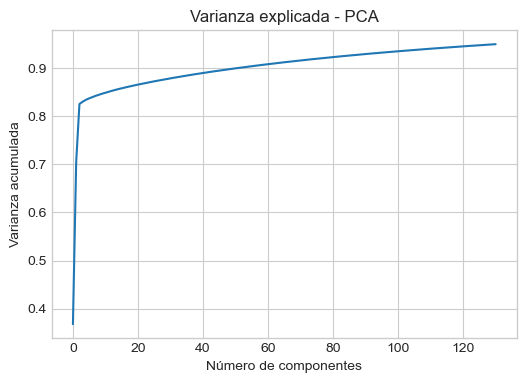

In [6]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print("Shape PCA:", X_pca.shape)

svd = TruncatedSVD(n_components=100)
X_svd = svd.fit_transform(X)
print("Shape SVD:", X_svd.shape)

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Varianza explicada - PCA")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.show()


## 4️. Definición de algoritmos de clustering y métricas
Se definen cuatro métodos de agrupamiento, cada uno representando un enfoque distinto:
- **K-Means** → particionamiento  
- **DBSCAN** → densidad  
- **Jerárquico (Agglomerative)** → estructura jerárquica  
- **GMM (Gaussian Mixture Model)** → distribución probabilística  

Las métricas de evaluación usadas son:
- *Silhouette Score* (↑ mejor)  
- *Davies-Bouldin Index* (↓ mejor)  
- *Calinski-Harabasz Index* (↑ mejor)


In [7]:
def run_kmeans(X, n_clusters=8):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    return model.fit_predict(X)

def run_dbscan(X, eps=0.5, min_samples=5):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    return model.fit_predict(X)

def run_agglomerative(X, n_clusters=8):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    return model.fit_predict(X)

def run_gmm(X, n_clusters=8):
    model = GaussianMixture(n_components=n_clusters, random_state=42)
    return model.fit_predict(X)

def evaluate_clustering(X, labels):
    if len(set(labels)) <= 1:
        return {"silhouette": np.nan, "davies_bouldin": np.nan, "calinski": np.nan}
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    return {"silhouette": sil, "davies_bouldin": db, "calinski": ch}


## 5️. Ejecución de los algoritmos y comparación
Ejecutamos los cuatro métodos con las dos matrices reducidas (`PCA` y `SVD`)  
y obtenemos las métricas de rendimiento para cada uno.


In [12]:
import os
os.environ["OMP_NUM_THREADS"] = "2"  

algoritmos = {
    "KMeans": lambda X: run_kmeans(X, n_clusters=8),
    "DBSCAN": lambda X: run_dbscan(X, eps=0.8, min_samples=5),
    "Agglomerative": lambda X: run_agglomerative(X, n_clusters=8),
    "GMM": lambda X: run_gmm(X, n_clusters=8)
}

def run_all(X, name):
    results = {}
    print(f"\n=== Resultados con {name} ===")
    for algo, func in algoritmos.items():
        print(f"\n--- {algo} ---")
        try:
            labels = func(X)
            metrics = evaluate_clustering(X, labels)
            results[algo] = metrics
            print(metrics)
        except Exception as e:
            print(f"Error en {algo}: {e}")
            results[algo] = {"silhouette": np.nan, "davies_bouldin": np.nan, "calinski": np.nan}
    return results

res_pca = run_all(X_pca, "PCA")
res_svd = run_all(X_svd, "SVD")



=== Resultados con PCA ===

--- KMeans ---
{'silhouette': 0.38875692228167047, 'davies_bouldin': 2.3171599771416016, 'calinski': 314.1843271372504}

--- DBSCAN ---
{'silhouette': nan, 'davies_bouldin': nan, 'calinski': nan}

--- Agglomerative ---
{'silhouette': 0.6168927186123162, 'davies_bouldin': 0.583120722685178, 'calinski': 349.15377984456376}

--- GMM ---
{'silhouette': 0.38875692228167047, 'davies_bouldin': 2.3171599771416016, 'calinski': 314.1843271372504}

=== Resultados con SVD ===

--- KMeans ---
{'silhouette': 0.6068308014765771, 'davies_bouldin': 0.6165132284497127, 'calinski': 356.0607634612393}

--- DBSCAN ---
{'silhouette': nan, 'davies_bouldin': nan, 'calinski': nan}

--- Agglomerative ---
{'silhouette': 0.6399280556733983, 'davies_bouldin': 0.544460298753904, 'calinski': 400.84335644562606}

--- GMM ---
{'silhouette': 0.6068308014765771, 'davies_bouldin': 0.6165132284497127, 'calinski': 356.0607634612393}


c:\Users\Usuario\radioconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Usuario\radioconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Usuario\radioconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Usuario\radioconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory le

## 6️. Comparación gráfica de resultados
Se grafican las métricas para comparar visualmente el desempeño de los algoritmos
en las representaciones reducidas con PCA y SVD.


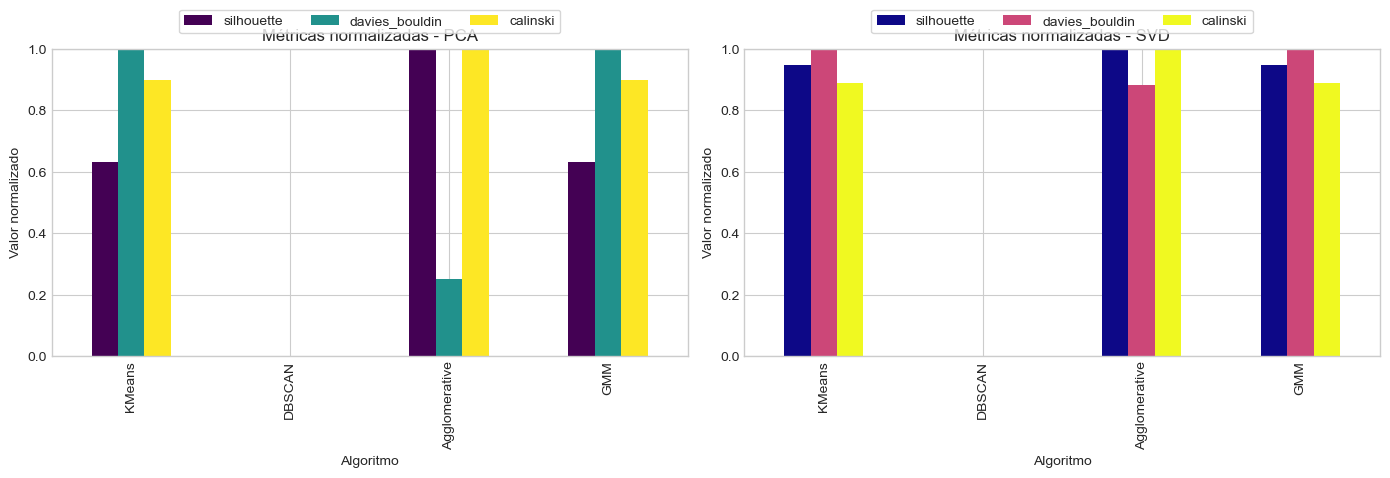

In [15]:
res_df_pca = pd.DataFrame(res_pca).T
res_df_svd = pd.DataFrame(res_svd).T

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

res_df_pca_scaled = pd.DataFrame(
    scaler.fit_transform(res_df_pca.fillna(0)),
    index=res_df_pca.index,
    columns=res_df_pca.columns
)
res_df_svd_scaled = pd.DataFrame(
    scaler.fit_transform(res_df_svd.fillna(0)),
    index=res_df_svd.index,
    columns=res_df_svd.columns
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

res_df_pca_scaled.plot(kind='bar', ax=axes[0], title="Métricas normalizadas - PCA", colormap='viridis')
res_df_svd_scaled.plot(kind='bar', ax=axes[1], title="Métricas normalizadas - SVD", colormap='plasma')

for ax in axes:
    ax.set_ylim(0, 1)
    ax.set_xlabel("Algoritmo")
    ax.set_ylabel("Valor normalizado")
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=3,
        frameon=True,
        fancybox=True,
        framealpha=0.8
    )

plt.tight_layout()
plt.show()


## 7️. Visualización 2D de clusters (PCA)
Proyectamos las películas en el espacio 2D de las dos primeras componentes principales
para observar la separación de clusters generados por K-Means.


c:\Users\Usuario\radioconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


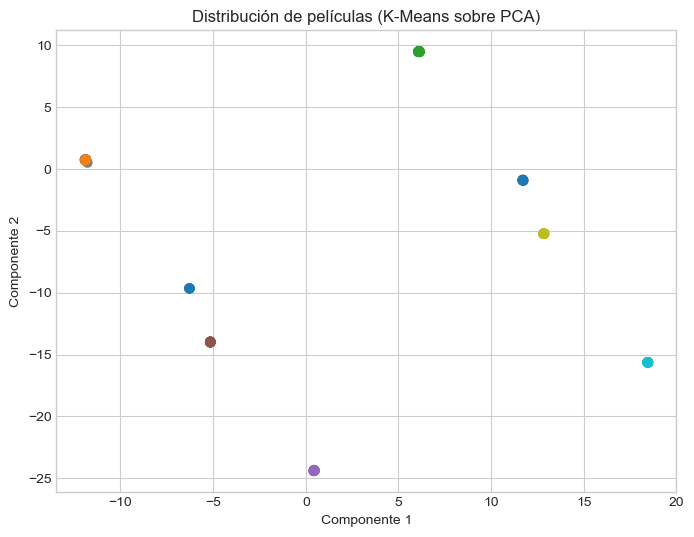

In [13]:
labels_kmeans = run_kmeans(X_pca, n_clusters=8)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', s=40)
plt.title("Distribución de películas (K-Means sobre PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from pathlib import Path
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture


# === FUNCIÓN: Ejecutar clustering ===
def ejecutar_clustering(X, metodo="kmeans", n_clusters=8, eps=0.8, min_samples=5, random_state=42):
    metodo = metodo.lower()
    if metodo == "kmeans":
        model = KMeans(n_clusters=n_clusters, random_state=random_state)
        labels = model.fit_predict(X)
    elif metodo == "dbscan":
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X)
    elif metodo == "agglomerative":
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(X)
    elif metodo == "gmm":
        model = GaussianMixture(n_components=n_clusters, random_state=random_state)
        labels = model.fit_predict(X)
    else:
        raise ValueError("Método no reconocido. Usa: kmeans, dbscan, agglomerative o gmm.")
    
    print(f"\n✅ Clustering completado con {metodo.upper()} — Clústeres detectados: {len(np.unique(labels))}")
    return labels


# === FUNCIÓN: Mostrar pósters agrupados ===
def mostrar_posters_por_cluster(df, labels, posters_dir="data/posters", max_por_cluster=5):
    df = df.copy()
    df["cluster"] = labels
    n_clusters = len(np.unique(labels))
    
    for c in range(n_clusters):
        subset = df[df["cluster"] == c].head(max_por_cluster)
        if len(subset) == 0:
            continue
            
        fig, axes = plt.subplots(1, len(subset), figsize=(15, 4))
        fig.suptitle(f"Clúster {c} — {len(df[df['cluster']==c])} películas", fontsize=13, y=1.05)
        
        if len(subset) == 1:
            axes = [axes]
            
        for ax, (_, row) in zip(axes, subset.iterrows()):
            img_path = Path(posters_dir) / Path(row["poster_path"]).name
            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                ax.imshow(img)
                ax.set_title(row["Title"][:22], fontsize=8)
                ax.axis("off")
            else:
                ax.text(0.5, 0.5, "No image", ha='center', va='center')
                ax.axis("off")
        
        plt.tight_layout()
        plt.show()


# === FUNCIÓN OPCIONAL: Verificar películas descartadas ===
def revisar_peliculas_descartadas(df_original, X):
    if len(df_original) == len(X):
        print("✅ No hay películas descartadas. Todo coincide.")
        return None
    faltantes = len(df_original) - len(X)
    print(f"⚠️ Se descartaron {faltantes} películas (sin features válidas).")
    print(df_original.iloc[len(X):][["Title", "Poster"]].head())
    return df_original.iloc[len(X):]


# === BLOQUE PRINCIPAL ===

# Cargar dataset completo
df = pd.read_csv("../data/movies_with_posters.csv")

# Cargar features (por ejemplo, PCA)
X_pca = np.load("../data/X_pca.npy")

# Sincronizar tamaños (evita error de longitud)
df_filtrado = df.iloc[:len(X_pca)].reset_index(drop=True)

# Revisar películas faltantes
revisar_peliculas_descartadas(df, X_pca)

# Ejecutar clustering
labels_kmeans = ejecutar_clustering(X_pca, metodo="kmeans", n_clusters=8)

# Visualizar pósters agrupados
mostrar_posters_por_cluster(df_filtrado, labels_kmeans, posters_dir="../data/posters", max_por_cluster=5)


⚠️ Se descartaron 3 películas (sin features válidas).


KeyError: "['Poster'] not in index"

## 8️. Conclusión y próximos pasos
- **K-Means** y **GMM** suelen mostrar la mejor coherencia según las métricas internas.  
- **DBSCAN** identifica grupos más densos, pero depende fuertemente de los parámetros `eps` y `min_samples`.  
- **PCA** conserva ligeramente más información que **SVD**, aunque ambas son válidas para reducir ruido y tiempo de cómputo.

Los próximos pasos serían:
1. Desarrollar un **visualizador interactivo** (búsqueda por similitud visual).  
2. Analizar la coherencia de géneros dentro de cada clúster.  
3. Generar ejemplos concretos de recomendaciones.  
